# Pricing models in the sequence space

# Imports

In [1]:
import numpy as np
from scipy import linalg, integrate, optimize, interpolate
import matplotlib.pyplot as plt

# some useful plot defaults
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (6, 3)})
plt.rcParams.update({'text.usetex': True, 'font.serif': 'Palatino'})

# Generalized time-dependent (TD) models
- Exogenous *survival function* $\Phi_s$ probability a price still in force $s$ periods after being set, starts at $\Phi_0=1$


- *Hazard rate* $\lambda_s \equiv (\Phi_{s-1} - \Phi_s)/\Phi_s$ of price being reset at $s$
    * Visit from "generalized Calvo fairy" with probability $\lambda_s$
    
    
- Objective when resetting in simple problem: minimize discounted quadratic loss function given shifter to log nominal marginal cost (normalized mean zero)
    * weighted by probability price still in effect!


$$
\hat{P}_t^* \equiv \arg \min_{\hat{P}} \sum_{s=0}^\infty \beta^s\Phi_s\frac{1}{2}(\hat{P}-\widehat{MC}_{t+s})^2 
$$

# Examples of time-dependent models
- Calvo: $\Phi_s = \theta^s$ for some Calvo adjustment rate $1-\theta$
    - *Constant hazard rate* $\lambda_s = 1-\theta$


- Taylor: $\Phi_s = 1$ for $s< N$ and $\Phi_s=0$ for $s \geq N$
    - Hazard rate is 0 until we reach $N$th period, where it becomes 1 (extreme example of *increasing hazard rate*)
    - Prices only last for $N$ periods, for some determinate $N$

# First-order condition for log reset price
- Want to set log prices equal to weighted average of future log prices:

$$
\hat{P}_t^* = \frac{\sum_{s=0}^\infty \beta^s\Phi_s\widehat{MC}_{t+s}}{\sum_{s=0}^\infty \beta^s\Phi_s}
$$


- In vectorized form:

$$
\hat{\mathbf{P}}^*= 
\frac{1}{\sum_{s=0}^\infty \beta^s \Phi_s}~
\begin{pmatrix}
\Phi_0 & \beta \Phi_1 & \beta^2 \Phi_2 & \cdots \\
0 & \Phi_0 & \beta \Phi_1 & \cdots \\
0 & 0 & \Phi_0 & \cdots \\
\vdots & \vdots & \vdots & \ddots
\end{pmatrix}
\widehat{\mathbf{MC}}
$$

# Aggregate prices
- Assume aggregate price index is average of prices currently in effect
    * (to first-order approximation around zero-inflation steady state)
    
    
- The distribution of ages of prices is proportional to survival function, so we have

$$\hat{P}_t = \frac{\sum_{s=0}^\infty \Phi_s \hat{P}_{t-s}^*}{\sum_{s=0}^\infty \Phi_s}$$


- In vectorized form:

$$
\hat{\mathbf{P}} = \frac{1}{\sum_{s=0}^\infty \Phi_s}~
\begin{pmatrix}
\Phi_0 & 0 & 0 & \cdots \\
\Phi_1 & \Phi_0 & 0 & \cdots \\
\Phi_2 & \Phi_1 & \Phi_0 & \cdots \\
\vdots & \vdots & \vdots & \ddots
\end{pmatrix}~\hat{\mathbf{P}}^*
$$

# Combining everything
Substituting first matrix equation into second to get matrix mapping $\widehat{\mathbf{MC}}$ to $\hat{\mathbf{P}}$:


$$
\hat{\mathbf{P}} = \underbrace{\frac{1}{\left(\sum_{s=0}^\infty \Phi_s\right)\left(\sum_{s=0}^\infty \beta^s \Phi_s\right)}~
\begin{pmatrix}
\Phi_0 & 0 & 0 & \cdots \\
\Phi_1 & \Phi_0 & 0 & \cdots \\
\Phi_2 & \Phi_1 & \Phi_0 & \cdots \\
\vdots & \vdots & \vdots & \ddots
\end{pmatrix}
\begin{pmatrix}
\Phi_0 & \beta \Phi_1 & \beta^2 \Phi_2 & \cdots \\
0 & \Phi_0 & \beta \Phi_1 & \cdots \\
0 & 0 & \Phi_0 & \cdots \\
\vdots & \vdots & \vdots & \ddots
\end{pmatrix}}_{\equiv \Psi}~
\widehat{\mathbf{MC}}
$$

We call this matrix the **pass-through matrix**, mapping shocks to log nominal marginal cost to changes in price

# Let's calculate this!
$$
\Psi \equiv \frac{1}{\left(\sum_{s=0}^\infty \Phi_s\right)\left(\sum_{s=0}^\infty \beta^s \Phi_s\right)}~
\begin{pmatrix}
\Phi_0 & 0 & 0 & \cdots \\
\Phi_1 & \Phi_0 & 0 & \cdots \\
\Phi_2 & \Phi_1 & \Phi_0 & \cdots \\
\vdots & \vdots & \vdots & \ddots
\end{pmatrix}
\begin{pmatrix}
\Phi_0 & \beta \Phi_1 & \beta^2 \Phi_2 & \cdots \\
0 & \Phi_0 & \beta \Phi_1 & \cdots \\
0 & 0 & \Phi_0 & \cdots \\
\vdots & \vdots & \vdots & \ddots
\end{pmatrix}
$$

In [2]:
def Psi_td(Phi, beta):
    T = len(Phi)
    beta_Phi = Phi*beta**np.arange(T)
    return 1/(Phi.sum() * beta_Phi.sum()) * np.tril(linalg.toeplitz(Phi)) @ np.triu(linalg.toeplitz(beta_Phi))

# Pass-through matrix for Calvo

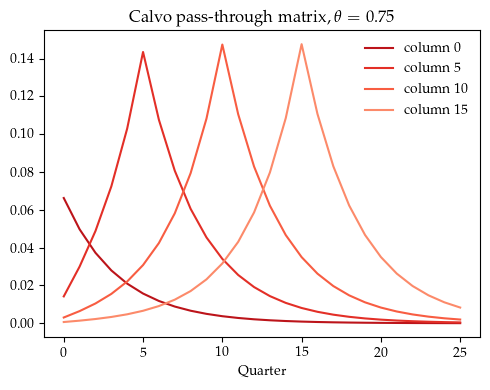

In [58]:
T = 800
beta = 0.98
theta = 0.75
Phi_calvo = theta**np.arange(T)
Psi_calvo = Psi_td(Phi_calvo, beta)

# plot this
plt.figure(figsize=(5, 4))
colors_calvo = plt.cm.Reds(np.linspace(0.4, 0.8, 4)[::-1])
for i, s in enumerate([0, 5, 10, 15]):
    plt.plot(Psi_calvo[:26, s], label=f'column {s}', color=colors_calvo[i])
plt.xlabel('Quarter')
plt.legend(frameon=False)
plt.title(f'Calvo pass-through matrix, $\\theta={theta}$')
plt.tight_layout()
plt.savefig('figures/lecture12_Calvo_Psi.pdf', transparent=True)

# Pass-through matrix for Taylor

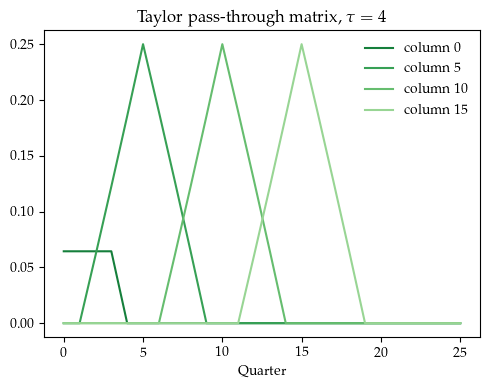

In [62]:
tau = 4
Phi_taylor = 1.*(np.arange(T) < tau)
Psi_taylor = Psi_td(Phi_taylor, beta)
# plt.plot(Psi_taylor[:21, [0, 5, 10]]);


# plot this
plt.figure(figsize=(5, 4))
colors_taylor = plt.cm.Greens(np.linspace(0.4, 0.8, 4)[::-1])
for i, s in enumerate([0, 5, 10, 15]):
    plt.plot(Psi_taylor[:26, s], label=f'column {s}', color=colors_taylor[i])
plt.xlabel('Quarter')
plt.legend(frameon=False)
plt.title(f'Taylor pass-through matrix, $\\tau={tau}$')
plt.tight_layout()
plt.savefig('figures/lecture12_Taylor_Psi.pdf', transparent=True)

# General points about pass-through matrices

- "Tent-shaped": an MIT shock to nominal marginal cost at some date passes through to aggregate shocks partly at that date...
    * but partly in anticipation
    * and partly afterward
    * as sticky prices are stuck after shock, and set in anticipation of shock
    
    
- Perfectly flexible prices correspond to identity matrix $\Psi=\mathbf{I}$
    * we're *assuming* that firms ideally want 100% pass-through if flexible
    * more generally, $\Psi$ is mapping from statically optimal prices to actual aggregate prices
    

- Impulse response to permanent nominal marginal cost shock given by $\Psi\cdot \mathbf{1}$, i.e. sum of columns
    * converges to 1, i.e full long-run pass-through

# New Keynesian Phillips curve: real marginal cost and inflation
The New Keynesian Phillips curve is derived in terms of *real marginal cost* $\widehat{mc}_t = \widehat{MC}_t - \hat{P}_t$:

$$
\pi_t = \kappa \widehat{mc}_t + \beta\pi_{t+1}
$$

which can then be related, in models, to the output gap, employment, etc.

How can we go from the pass-through matrix, relating *nominal marginal cost* and *prices*, to something like this, relating *real marginal cost* and *inflation*?

# Solving fixed point
We get a fixed-point equation—*conditional* on real marginal cost, prices themselves affect the price-setting decision:

$$
\hat{\mathbf{P}} = \Psi \cdot\widehat{\mathbf{MC}} = \Psi \cdot(\widehat{\mathbf{mc}} + \hat{\mathbf{P}})
$$

Solving this gives:

$$
\hat{\mathbf{P}} = (\mathbf{I}-\Psi)^{-1}\cdot \Psi \cdot \widehat{\mathbf{mc}}
$$

Equivalent to $\hat{\mathbf{P}} = (\Psi + \Psi ^2 + \Psi^3 + \ldots)\cdot \widehat{\mathbf{mc}}$, representing "rounds" of feedback

Finally, first differences to obtain inflation:

$$
\boldsymbol{\pi} = \underbrace{(\mathbf{I}-\mathbf{L})\cdot (\mathbf{I}-\Psi)^{-1}\cdot \Psi}_{\equiv \mathbf{K}} \cdot \widehat{\mathbf{mc}}
$$

# Generalized Phillips curve
We have

$$
\boldsymbol{\pi} = \underbrace{(\mathbf{I}-\mathbf{L})\cdot (\mathbf{I}-\Psi)^{-1}\cdot \Psi}_{\equiv \mathbf{K}} \cdot \widehat{\mathbf{mc}}
$$

and call matrix $\mathbf{K}$ mapping real marginal cost to inflation the *generalized Phillips curve*

Generalized Phillips curve for Calvo is matrix representation of NKPC:

$$
\mathbf{K} = 
\begin{pmatrix}
\kappa & \beta\kappa & \beta^2\kappa & \cdots \\
0 & \kappa & \beta\kappa & \cdots \\
0 & 0 & \kappa & \cdots \\
\vdots & \vdots & \vdots & \ddots
\end{pmatrix}
$$

# Calculate generalized Phillips curve
Need high $T$ to avoid artifacts from truncation close to $T$, but can implement formula directly:

In [63]:
def K_from_Psi(Psi):
    T = len(Psi)
    
    # calculate (I-Psi)^(-1)*Psi
    K = np.linalg.solve(np.eye(T) - Psi, Psi)
    
    # apply (I-L) to this, i.e. take first difference in rows
    K[1:] -= K[:-1]
    
    return K

# Get what we expect for Calvo!

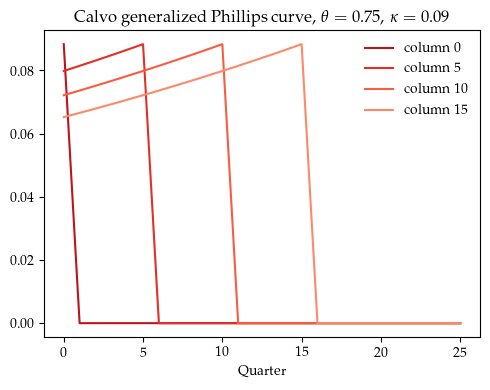

In [138]:
K_calvo = K_from_Psi(Psi_calvo)
# plt.plot(K_calvo[:21, [0, 5, 10, 15]]);
kappa = (1 - theta) * (1 - beta * theta) / theta

# plot this
plt.figure(figsize=(5, 4))
colors_calvo = plt.cm.Reds(np.linspace(0.4, 0.8, 4)[::-1])
for i, s in enumerate([0, 5, 10, 15]):
    plt.plot(K_calvo[:26, s], label=f'column {s}', color=colors_calvo[i])
plt.xlabel('Quarter')
plt.legend(frameon=False)
plt.title(f'Calvo generalized Phillips curve, $\\theta={theta}$, $\\kappa={kappa:.2f}$')
plt.tight_layout()
plt.savefig('figures/lecture12_Calvo_K.pdf', transparent=True)

# Something much uglier for Taylor, with a bit of inertia
Note: this looks like numerical error, but isn't—the generalized Phillips curve for Taylor pricing is really this ugly-looking!

Inertia: inflation persists a bit after real marginal cost shocks (at dates 0, 5, 10, 15):

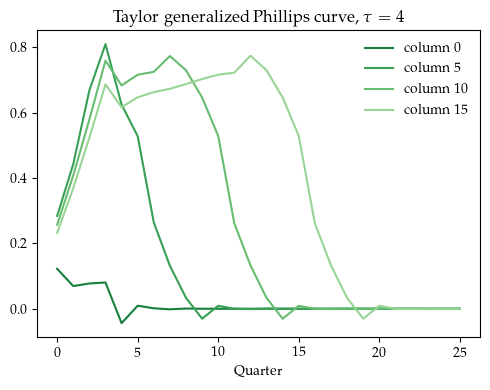

In [139]:
K_taylor = K_from_Psi(Psi_taylor)


# plot this
plt.figure(figsize=(5, 4))
for i, s in enumerate([0, 5, 10, 15]):
    plt.plot(K_taylor[:26, s], label=f'column {s}', color=colors_taylor[i])
plt.xlabel('Quarter')
plt.legend(frameon=False)
plt.title(f'Taylor generalized Phillips curve, $\\tau={tau}$')
plt.tight_layout()
plt.savefig('figures/lecture12_Taylor_K.pdf', transparent=True)

# Smoother version of increasing hazard

In [140]:
lamb_ih = 0.5*(1 - 0.8 ** np.arange(T-1))
Phi_ih = np.ones(T)
Phi_ih[1:] = np.cumprod(1-lamb_ih) # survival from 1 onward is cumulative product of 1-hazard

Plot hazard rate of price adjustment:

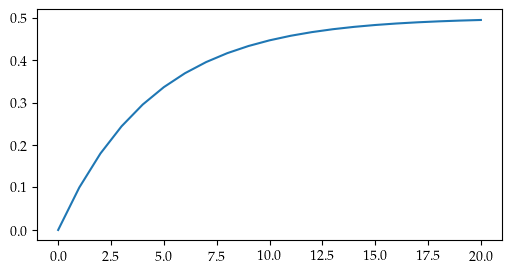

In [141]:
plt.plot(lamb_ih[:21]);

# Generalized Phillips curve for this case: smoother, still with inertia

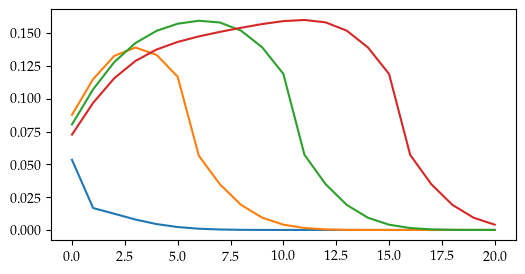

In [142]:
Psi_ih = Psi_td(Phi_ih, beta)
K_ih = K_from_Psi(Psi_ih)
plt.plot(K_ih[:21, [0, 5, 10, 15]]);

# But this case looks a lot like Calvo in the long run...
Same $\beta$ rate of decay in anticipation (can prove this!), mostly forward-looking, inertia small in comparison!

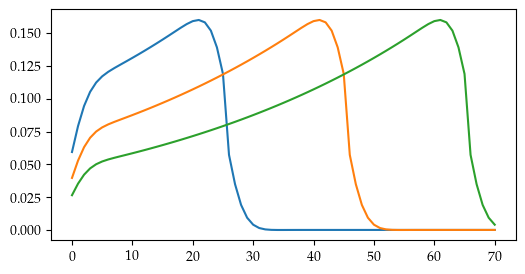

In [143]:
plt.plot(K_ih[:71, [25, 45, 65]]);

# Opposite case: decreasing hazard, anti-inertia

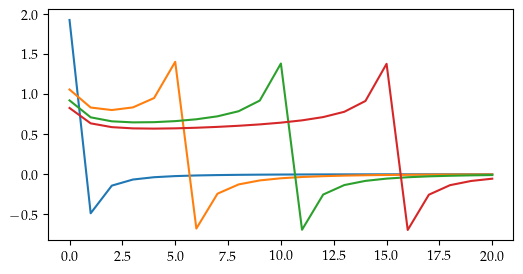

In [144]:
lamb_dh = 0.2*(1 + 3*0.8** np.arange(T-1))
Phi_dh = np.ones(T)
Phi_dh[1:] = np.cumprod(1-lamb_dh)
Psi_dh = Psi_td(Phi_dh, beta)
K_dh = K_from_Psi(Psi_dh)
plt.plot(K_dh[:21, [0, 5, 10, 15]]);

# Also looks more like Calvo in long run...
Long-run decay of anticipation at rate $\beta$, distinct behavior confined to neighborhood of shock (and date 0)

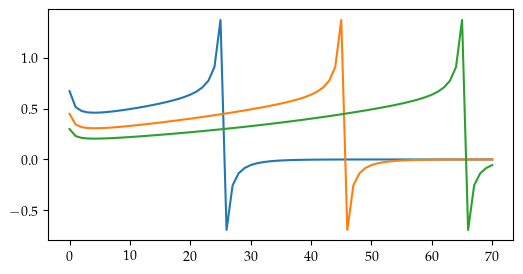

In [145]:
plt.plot(K_dh[:71, [25, 45, 65]]);

# Summary of what we've learned for time-dependent

- No generalized Phillips curves look *too* different from Calvo
    * they're all more forward-looking than backward-looking, with anticipation decaying at $\beta$
    

- Increasing hazards lead to a bit of inertia (and vice versa for decreasing hazards)


- Intuition: with increasing hazards, people resetting prices today are more likely not to have reset prices recently...


- ... so they missed any recent inflation, and need to set higher prices to "catch up", resulting in inertial inflation

# Nerdy sequence-space Jacobian side note
The pass-through matrix is a sequence-space Jacobian, and TD $\Psi$ has fake news matrix $F_{t,s} = J_{t,s} - J_{t-1,s-1}$ equal to a simple rank-one matrix:

$$
F \equiv \frac{1}{\left(\sum_{s=0}^\infty \Phi_s\right)\left(\sum_{s=0}^\infty \beta^s \Phi_s\right)}~
\begin{pmatrix}
\Phi_0 \\
\Phi_1 \\
\Phi_2 \\
\vdots 
\end{pmatrix}
\begin{pmatrix}
\Phi_0 & \beta \Phi_1 & \beta^2 \Phi_2 & \cdots
\end{pmatrix}
$$

A "fake news" shock about future marginal costs at $s$ leads to an increase in reset prices at date 0 in proportion to $\beta^s \Phi_s$, which has a persistent effect at date $t$ in proportion to $\Phi_t$

# Nerdy side note continued: recovering survival function

In [146]:
F_calvo = Psi_calvo.copy()
F_calvo[1:, 1:] -= Psi_calvo[:-1, :-1]

Only one nonzero singular value, i.e. this is rank one:

In [147]:
u, s, vh = np.linalg.svd(F_calvo[:100, :100]) # not looking out to T to avoid artifacts of truncation
s[:5]

array([1.47714857e-01, 4.75802518e-17, 4.49762166e-17, 4.17404531e-17,
       3.74726930e-17])

Corresponding singular vectors are proportional to $\Phi_s$ and $\beta^s \Phi_s$, respectively, can rescale so first entry is 1 and see exponential decay:

In [148]:
u[:6, 0] / u[0, 0]

array([1.        , 0.75      , 0.5625    , 0.421875  , 0.31640625,
       0.23730469])

In [149]:
vh[0, :6] / vh[0, 0]

array([1.        , 0.735     , 0.540225  , 0.39706538, 0.29184305,
       0.21450464])

# Other detour: mixture models
Can easily assume fraction of firms follow one TD rule, fraction follow another, just by combining pass-through matrices.

For instance, let's try simple Calvo mixture, with some more flexible and some less, averaging out to same 0.25 frequency of price change:

In [150]:
Phi_sticky = 0.9**np.arange(T)
Phi_flex = 0.6**np.arange(T)

Psi_sticky = Psi_td(Phi_sticky, beta)
Psi_flex = Psi_td(Phi_flex, beta)
Psi_mixture = 0.5*Psi_sticky + 0.5*Psi_flex

# Generalized Phillips curve shows anti-inertia
Same intuition as decreasing hazards: price-setters are more likely to have recently reset, so they lower prices after inflation to go closer to sticky counterparts

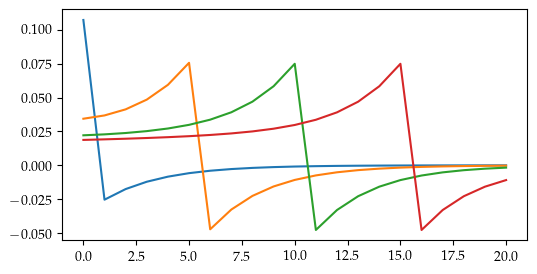

In [151]:
K_mixture = K_from_Psi(Psi_mixture)
plt.plot(K_mixture[:21, [0, 5, 10, 15]]);

# Menu cost models

# Basic menu cost model
Continuum of firms, assume their ideal log price $p_{it}^*$ follows random walk $p_{it}^* = p_{it-1}^* + \epsilon_{it}$ with symmetric, mean-zero shocks $\epsilon_{it}$.

Defining idiosyncratic *price gap* as $x_{it}\equiv p_{it} - p_{it}^*$, firm objective in simple model becomes

$$
\min_{\{x_{it}\}} \mathbb{E}_0 \sum_{t=0}^\infty \beta^t
\left[
\frac{1}{2}(x_{it} - \widehat{MC}_t)^2 + \xi 1_{x_{it}\neq x_{it-1}-\epsilon_{it}}
\right]
$$

i.e. pick a state-contingent plan for price gaps $x_{it}$ to minimize quadratic loss, subject to time-varying aggregate marginal cost shocks, and a *menu cost* $\xi$ for adjusting your price (i.e. not letting price gap drift with shocks)

# Optimal policy is "Ss" rule
Optimal policy: adjust to reset point $x_t^*$ if shock takes you outside adjustment bands $[\underline{x}_t, \overline{x}_t]$

$$
x_{it} = 
\begin{cases}
x_t ^* & \text{if }x_{it-1} - \epsilon_{it} \notin [\underline{x}_t, \overline{x}_t] \\
x_{it-1} - \epsilon_{it} & \text{otherwise}
\end{cases}
$$

Note policies $(x_t ^*, \underline{x}_t, \overline{x}_t)$ common across all firms $i$

Symmetry of shocks implies $x_t^* = 0$ and $\underline{x}_t = -\overline{x}_t$ in steady state

# Law of motion for density of price gaps
Let $g(x)$ be steady-state density of price gaps $x_{it-1} - \epsilon_{it}$ in any period, "before" firms outside bands have adjusted to $x_t^*$, and $\text{freq}$ be steady-state fraction of firms adjusting:

$$
\text{freq} = 1 - \int_{-\bar{x}}^{\bar{x}} g(x)dx
$$

$$
g(x) = \text{freq}\cdot f(x) + \int_{-\bar{x}}^{\bar{x}} f(x-x')g(x')dx'
$$

# Calculate steady-state density $g$
Assume shocks to ideal log price normal, define first mean-zero normal pdf:

In [152]:
C = 1/np.sqrt(2*np.pi)
def normal_pdf(x, sigma):
    return C/sigma*np.exp(-(x/sigma)**2/2)

We'll assume quarterly calibration where standard deviation of shocks is 0.05 (roughly calibrated value from our paper):

In [153]:
sigma = 0.05 # roughly the calibrated value in our New Pricing Models paper
def f(x):
    return normal_pdf(x, sigma)

# Steady-state density continued
Assume we're given adjustment band $\overline{x}$ (and by symmetry $-\overline{x}$ on other side), iterate on law of motion for $g$:

In [154]:
def ss_dist(xbar):
    xs = np.linspace(-xbar, xbar, 60) # 60 nodes for cubic spline, could exploit symmetry
    gxs = np.full(60, 1/(2*xbar)) # initially guess uniform
    g = interpolate.CubicSpline(xs, gxs)
    
    for it in range(100):
        freq = 1 - g.integrate(-xbar, xbar) # frequency of price adjustment
        
        # evaluate g(x) at each node x for cubic spline, reinterpolate
        # painfully inefficient to call cubic spline over and over again w/overhead
        # but we won't bother with more efficiency here
        gxs_new = (freq*f(xs) 
            + np.array([integrate.quad(lambda xp: f(x - xp)*g(xp), -xbar, xbar)[0] for x in xs]))
        g = interpolate.CubicSpline(xs, gxs_new)
        
        if np.max(np.abs(gxs_new - gxs)) < 1E-10:
            return g
        gxs = gxs_new
        
    raise ValueError('No convergence')

# Plot density for arbitrary $\overline{x}$:

In [155]:
xbar = 0.1
g = ss_dist(xbar)
freq = 1 - g.integrate(-xbar, xbar)
freq

0.144644487570309

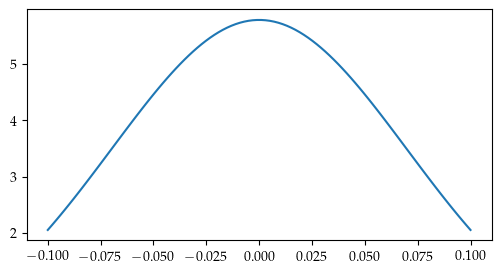

In [156]:
xs = np.linspace(-xbar, xbar, 100)
plt.plot(xs, g(xs));

# Calibrate $\bar{x}$ to hit average frequency of 0.25
Don't need to know $\xi$ itself to do this!

In [157]:
xbar = optimize.brentq(lambda xbar: ss_dist(xbar).integrate(-xbar, xbar) - 0.75, 0.01, 0.1)
xbar

0.06779121612923501

In [158]:
g = ss_dist(xbar)
freq = 1 - g.integrate(-xbar, xbar)
freq

0.249999999999991

# Actual density looks similar to what we already saw

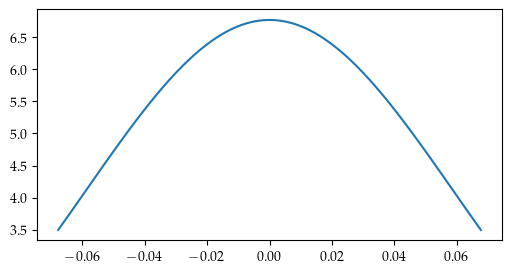

In [159]:
xs = np.linspace(-xbar, xbar, 100)
plt.plot(xs, g(xs));

# Defining expectation functions in our context (cf fake news algorithm)
If end-of-period price gap is $x$ today, what (following steady-state policy) will it be on average in $t$ periods? 

Law of iterated expectations, plus symmetry (reset to zero, where expectations are zero), imply:

$$
E^t(x) = \int_{-\overline{x}}^{\overline{x}} f(x'-x)E^{t-1}(x')dx'
$$

In [160]:
xs = np.linspace(-xbar, xbar, 60)
def E_recursion(E):
    Exs = [integrate.quad(lambda xp: f(xp - x)*E(xp), -xbar, xbar)[0] for x in xs]
    return interpolate.CubicSpline(xs, Exs)

# Plot some expectation functions
Decay much faster than probability of resetting prices, due to "selection effects"

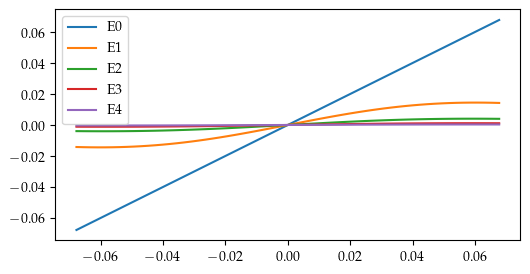

In [161]:
E0 = lambda x: x
Es = [E0]
for i in range(4):
    Es.append(E_recursion(Es[-1]))

for i in range(5):
    plt.plot(xs, Es[i](xs), label=f'E{i}')
plt.legend();

# Or ignore the first to see typical shape

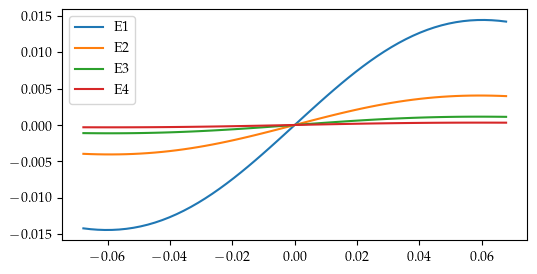

In [162]:
for i in range(1, 5):
    plt.plot(xs, Es[i](xs), label=f'E{i}')
plt.legend();

# Exactly how fast do these decay?
Let's look at "persistence" of expectation function starting from reset point $x^*=0$ or adjustment band $\overline{x}=0$:

$$
\Phi_t^e \equiv \frac{E^t(\overline{x})}{\overline{x}}~~~~~~~~~~~~~
\Phi_t^i \equiv E^{t \prime}(0) = \lim_{x\rightarrow 0} \frac{E^t(x)}{x}
$$

In [163]:
TPhi = 30
Phi_e = np.empty(TPhi)
Phi_i = np.empty(TPhi)

Et = interpolate.CubicSpline(xs, xs) # identity
for t in range(TPhi):
    Phi_e[t] = Et(xbar)/xbar
    Phi_i[t] = Et.derivative()(0)
    Et = E_recursion(Et)

# Very fast decay
Initially persistence at $\bar{x}$ is less, because people are more likely to adjust there:

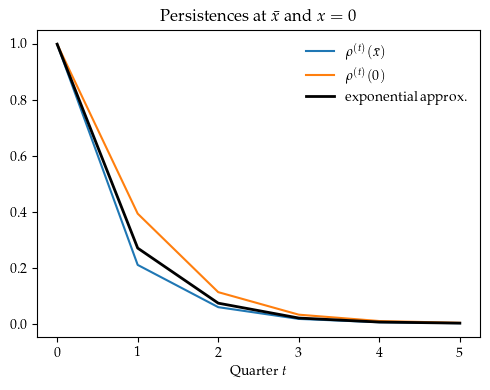

In [168]:
plt.figure(figsize=(5, 4))
plt.plot(Phi_e[:6], label=r'$\rho^{(t)}(\bar x)$')
plt.plot(Phi_i[:6], label=r'$\rho^{(t)}(0)$')
plt.xlabel('Quarter $t$')
plt.legend(frameon=False)
plt.title(f'Persistences at $\\bar x$ and $x=0$')
plt.tight_layout()
plt.savefig('figures/lecture12_menucost_persistences.pdf', transparent=True)

# But "hazard" *very* quickly approaches same constant

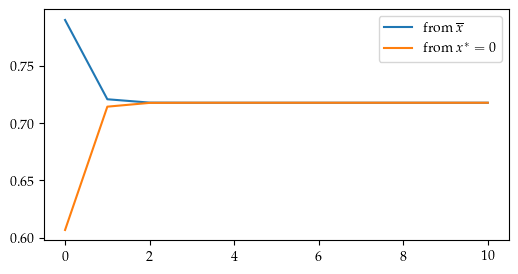

In [94]:
lambda_e = (Phi_e[:-1] - Phi_e[1:])/Phi_e[:-1]
lambda_i = (Phi_i[:-1] - Phi_i[1:])/Phi_i[:-1]
plt.plot(lambda_e[:11], label=r'from $\overline{x}$')
plt.plot(lambda_i[:11], label=r'from $x^*=0$')
plt.legend();

# Can also iterate to track actual "survival probability" of prices

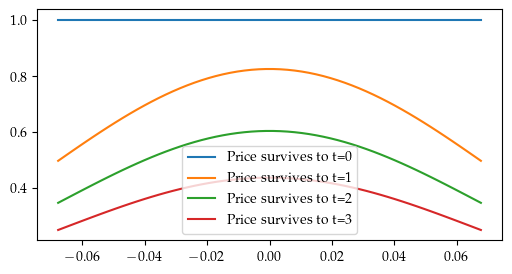

In [95]:
TPhi = 30
Phi_actual = np.empty(TPhi)
Et_noreset = interpolate.CubicSpline(xs, np.ones(len(xs)))
for t in range(TPhi):
    if t < 4:
        plt.plot(xs, Et_noreset(xs), label=f'Price survives to t={t}')
    Phi_actual[t] = Et_noreset(0)
    Et_noreset = E_recursion(Et_noreset)
plt.legend();

# Decays *much* more slowly than persistences—"selection effect"!

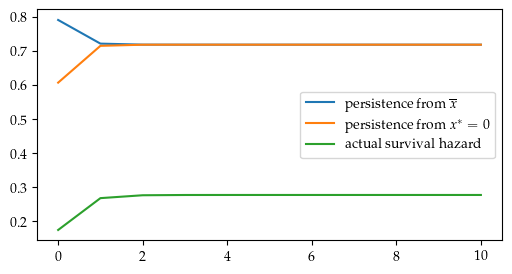

In [96]:
lambda_actual = 1 - Phi_actual[1:] / Phi_actual[:-1]
plt.plot(lambda_e[:11], label=r'persistence from $\overline{x}$')
plt.plot(lambda_i[:11], label=r'persistence from $x^* =0$')
plt.plot(lambda_actual[:11], label='actual survival hazard')
plt.legend();

# Proposition 1 from Auclert, Rigato, Rognlie, Straub (2023)
Assume aggregate price is average of price gaps, $\hat{P}_t = \int x_{it}di$ (idiosyncratic shocks average out to zero, so price gaps give price level)


The pass-through matrix from nominal marginal cost to price for the menu cost model is given by a *mixture of time-dependent models*

$$
\Psi = \alpha \Psi^{\Phi^e} + (1-\alpha)\Psi^{\Phi^i}
$$

where $\Psi^{\Phi^e}$ and $\Psi^{\Phi^i}$ are pass-through matrices with survivals $\Phi^e_t$ and $\Phi^i_t$

First term gives effect of *extensive margin*, second term gives effect of *intensive margin*, with weight on extensive margin of $\alpha \equiv 2g(\overline{x})\overline{x}\sum_{t=0}^\infty \Phi_t^e$

# Partial intuition: "persistence" at $\overline{x}$ gives persistent effect of  extensive margin decisions
- Suppose I'm right at the threshold $\overline{x}$ and decide not to adjust today

    - effect on price level today: $+\overline{x}$
    
    - effect tomorrow: $+E^1(\overline{x})$
    
    - ... effect in $t$ periods: $+E^t(\overline{x})$
    

- Expectation function summarizes effect of my decision today on future price level
    - it incorporates fact that if I don't adjust today, I'll probably adjust soon anyway
    - "persistence" of effect is $\Phi^e_t = E^t(\overline{x}) / \overline{x}$

# Re-plot expectation functions to visualize this

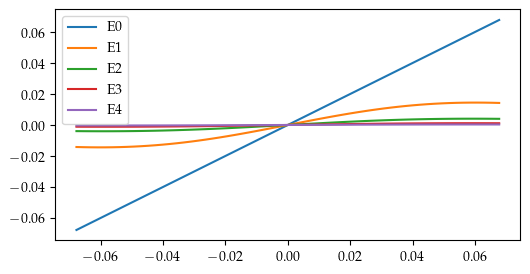

In [97]:
for i in range(5):
    plt.plot(xs, Es[i](xs), label=f'E{i}')
plt.legend();

# Partial intuition, continued: "persistence" at $x^*=0$ gives persistent effect of intensive margin decisions
- Suppose I'm adjusting and I decide to raise my price by $dx^*$, slightly above zero

    - effect on price level today: $+dx^*$
    
    - effect tomorrow: $+E^1(dx^*) = +E^{1\prime}(0)dx^*$
    
    - ... effect in $t$ periods: $+E^{t\prime}(0)dx^*$
    

- Again, expectation function summarizes effect decision today on future price level
    - incorporates fact that if I set higher price today, I'm more likely to adjust downward in future
    - "persistence" of higher price is $\Phi^i_t +E^{t\prime}(0)$

# Taking stock
- We've seen that extensive margin decisions "persist" at $\Phi_t^e$, intensive margin decisions "persist" at $\Phi_t^i$, each like in a properly calibrated time-dependent model


- But that's only one side of time-dependent models!


- Key to time-dependent models is that *future* matters proportional to $\beta^s \Phi_s$!
    - Recall reset-price equation for time-dependent case:


$$
\hat{P}_t^* = \frac{\sum_{s=0}^\infty \beta^s\Phi_s\widehat{MC}_{t+s}}{\sum_{s=0}^\infty \beta^s\Phi_s}
$$

# What's intuition for why future shocks matter in proportion to $\Phi_s$?
- Loose intuition: when making a decision at extensive or intensive margin, you care about future marginal costs only insofar as your decision today actually affects your future price
    - and that's *exactly* what these persistences $\Phi_t^e$ and $\Phi_t^i$ are capturing!
    

- More formal intuition: envelope theorem argument implies that if there's some perturbation $\widehat{MC}_s$, then for $t<s$, we have same recursion as for expectation functions, with added $\beta$:

$$
dV_t(x) = \beta \mathbb{E}_{x'|x} dV_{t+1}(x')
$$
   
   
- Since $dV_s(x) = -x = -E^0(x)$, follows that $dV_t(x) = -\beta^s E^{s-t}(x)$
    * future marginal costs affect value function in proportion to expectation function!

# Let's implement!
Pad with zeros to get $T$-length, build pass-through matrices for extensive and intensive margin:

In [98]:
Phi_e_long = np.zeros(T)
Phi_e_long[:TPhi] = Phi_e
Psi_e = Psi_td(Phi_e_long, beta)

Phi_i_long = np.zeros(T)
Phi_i_long[:TPhi] = Phi_i
Psi_i = Psi_td(Phi_i_long, beta)

Weight extensive by $\alpha$, intensive by $1-\alpha$:

In [99]:
alpha = 2*g(xbar)*xbar*Phi_e.sum()
alpha

0.612530214997201

In [100]:
Psi = alpha*Psi_e + (1-alpha)*Psi_i

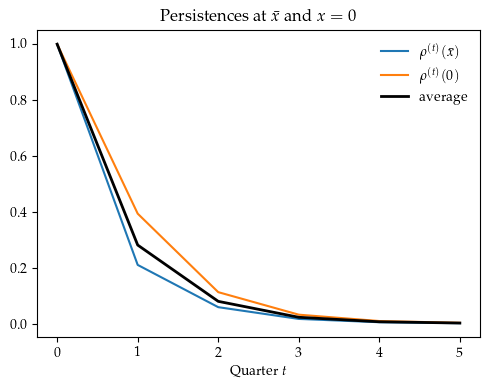

In [169]:
plt.figure(figsize=(5, 4))
plt.plot(Phi_e[:6], label=r'$\rho^{(t)}(\bar x)$')
plt.plot(Phi_i[:6], label=r'$\rho^{(t)}(0)$')
# plt.plot(0.27 ** np.arange(6), color='black', linewidth=2, label='exponential approx.')
plt.plot(alpha * Phi_e[:6] + (1-alpha) * Phi_i[:6], color='black', linewidth=2, label='average')
plt.xlabel('Quarter $t$')
plt.legend(frameon=False)
plt.title(f'Persistences at $\\bar x$ and $x=0$')
plt.tight_layout()
plt.savefig('figures/lecture12_menucost_persistences.pdf', transparent=True)

# Visualize pass-through matrix
Very sharp spikes, corresponding to near-flexible prices (rapidly declining "virtual survival", i.e. low persistence of decisions):

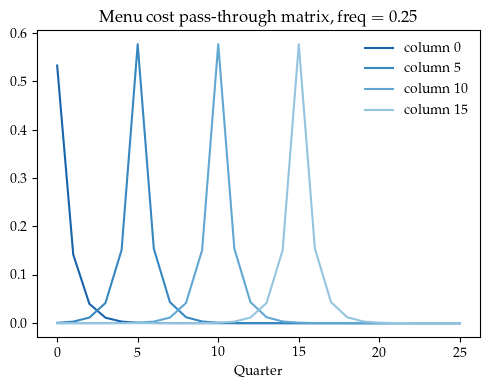

In [101]:
# plt.plot(Psi[:21, [0, 5, 10]]);

# plot this
plt.figure(figsize=(5, 4))
colors_mc = plt.cm.Blues(np.linspace(0.4, 0.8, 4)[::-1])
for i, s in enumerate([0, 5, 10, 15]):
    plt.plot(Psi[:26, s], label=f'column {s}', color=colors_mc[i])
plt.xlabel('Quarter')
plt.legend(frameon=False)
plt.title(f'Menu cost pass-through matrix, freq $=0.25$')
plt.tight_layout()
plt.savefig('figures/lecture12_menucost_Psi.pdf', transparent=True)

In [170]:
from scipy.optimize import minimize

def objective(theta):
        Phi_calvo = theta**np.arange(T)
        Psi_calvo = Psi_td(Phi_calvo, beta)
        return np.linalg.norm(Psi - Psi_calvo)
    
# Minimize the objective function over theta in the range [0, 1)
result = minimize(objective, x0=[0.5], bounds=[(0, 1)])

# Get the optimal theta and the corresponding Calvo Psi
optimal_theta = result.x[0]
Phi_opt = optimal_theta ** np.arange(T)
Psi_opt = Psi_td(Phi_opt, beta)

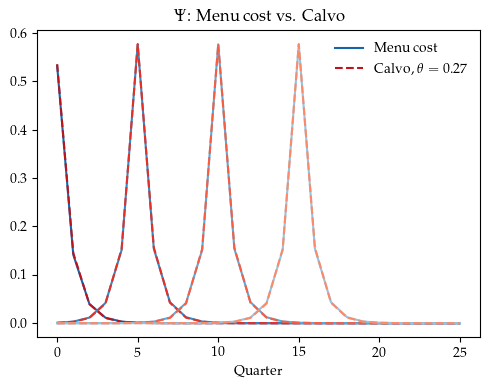

In [171]:
# plot this
plt.figure(figsize=(5, 4))
for i, s in enumerate([0, 5, 10, 15]):
    if i == 0:
        plt.plot(Psi[:26, s], label=f'Menu cost', color=colors_mc[i])
        plt.plot(Psi_opt[:26, s], label=f'Calvo, $\\theta = {optimal_theta:.2f}$', color=colors_calvo[i], linestyle='dashed')
    else:
        plt.plot(Psi[:26, s], color=colors_mc[i])
        plt.plot(Psi_opt[:26, s], color=colors_calvo[i], linestyle='dashed')
plt.xlabel('Quarter')
plt.legend(frameon=False)
plt.title(f'$\Psi$: Menu cost vs. Calvo')
plt.tight_layout()
plt.savefig('figures/lecture12_menucost_Psi_matched.pdf', transparent=True)

# What about generalized Phillips curve?
Insanely close to the Calvo New Keynesian Phillips curve, but a lot more flexible (slope of 2, not 0.1)!

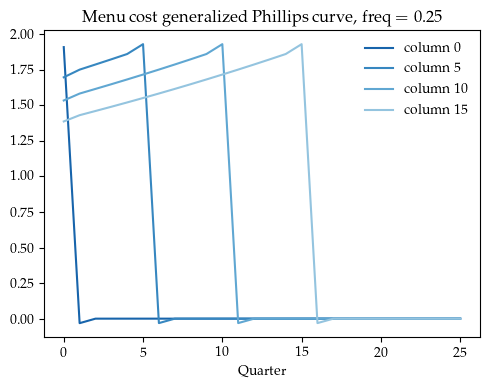

In [172]:
K = K_from_Psi(Psi)
# plt.plot(K[:21, [0, 5, 10, 15]]);

# plot this
plt.figure(figsize=(5, 4))
for i, s in enumerate([0, 5, 10, 15]):
    plt.plot(K[:26, s], label=f'column {s}', color=colors_mc[i])
plt.xlabel('Quarter')
plt.legend(frameon=False)
plt.title(f'Menu cost generalized Phillips curve, freq $=0.25$')
plt.tight_layout()
plt.savefig('figures/lecture12_menucost_K.pdf', transparent=True)

In [173]:
# match this with calvo K

def objective(theta):
        Phi_calvo = theta**np.arange(T)
        Psi_calvo = Psi_td(Phi_calvo, beta)
        K_calvo = K_from_Psi(Psi_calvo)
        return np.linalg.norm(K_calvo - K)
    
# Minimize the objective function over theta in the range [0, 1)
result = minimize(objective, x0=[optimal_theta], bounds=[(0, 1)])

# Get the optimal theta and the corresponding Calvo Psi
optimal_theta_K = result.x[0]
kappa_opt = (1 - optimal_theta_K) * (1 - beta * optimal_theta_K) / optimal_theta_K
Phi_opt_K = optimal_theta_K ** np.arange(T)
Psi_opt_K = Psi_td(Phi_opt_K, beta)
K_opt = K_from_Psi(Psi_opt_K)

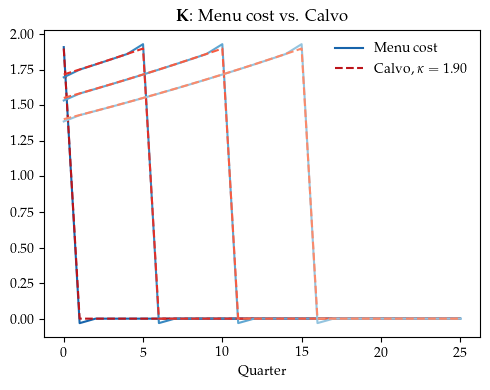

In [174]:
# plot this
plt.figure(figsize=(5, 4))
for i, s in enumerate([0, 5, 10, 15]):
    if i == 0:
        plt.plot(K[:26, s], label=f'Menu cost', color=colors_mc[i])
        plt.plot(K_opt[:26, s], label=f'Calvo, $\\kappa = {kappa_opt:.2f}$', color=colors_calvo[i], linestyle='dashed')
    else:
        plt.plot(K[:26, s], color=colors_mc[i])
        plt.plot(K_opt[:26, s], color=colors_calvo[i], linestyle='dashed')
plt.xlabel('Quarter')
plt.legend(frameon=False)
plt.title(f'$\mathbf K$: Menu cost vs. Calvo')
plt.tight_layout()
plt.savefig('figures/lecture12_menucost_K_matched.pdf', transparent=True)

# Why is this?
Both extensive and intensive very quickly converge to the same constant hazard (corresponding to leading odd eigenvalue—cf Alvarez and Lippi Ecta 2022 and our paper), much higher than actual probability of adjusting (near 0.25)...

... so **they behave like a Calvo, but one with more like a 0.7 quarterly adjustment frequency!**

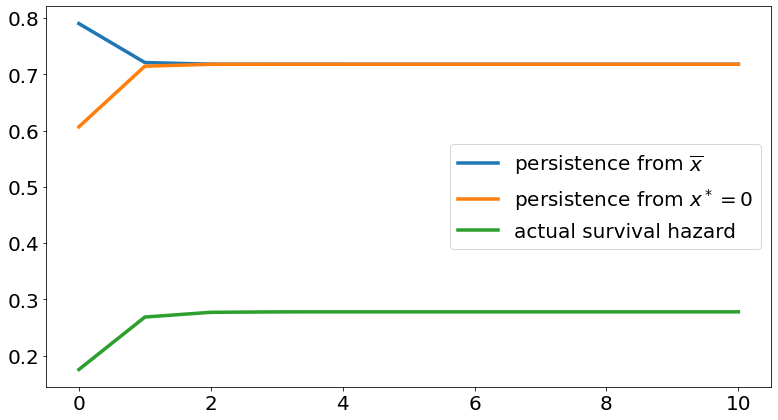

In [93]:
plt.plot(lambda_e[:11], label=r'persistence from $\overline{x}$')
plt.plot(lambda_i[:11], label=r'persistence from $x^* =0$')
plt.plot(lambda_actual[:11], label='actual survival hazard')
plt.legend();

# Adding "free resets"

# Modified menu cost model with free resets
- Suppose that there's a $\lambda$ chance of a "free reset", where menu cost is zero
    * Then always adjust back to $x_t^*$
    * Higher $\lambda$ as share of total resets means adjustment is less state-dependent, more Calvo-like
    * Close to "Calvo-Plus" model of Nakamura and Steinsson, also others in literature
    
    
- We'll redo steps quickly modifying the model to account for this, not going into much detail
    * We'll calibrate to $\lambda=0.2$ and still adjustment frequency of 0.25, so that four-fifths of adjustments are free
    * Same equivalence result holds with suitably redefined expectations functions and weights!

# Modified steady-state density function (almost same as before)

In [98]:
lamb = 0.2
def ss_dist(xbar, tol=1E-7):
    xs = np.linspace(-xbar, xbar, 60)
    gxs = np.full(60, 1/(2*xbar))
    g = interpolate.CubicSpline(xs, gxs)
    
    for it in range(120):
        freq = 1 - (1-lamb)*g.integrate(-xbar, xbar)
        gxs_new = (freq*f(xs) 
            + np.array([integrate.quad(lambda xp: (1-lamb)*f(x - xp)*g(xp), -xbar, xbar)[0] for x in xs]))
        g = interpolate.CubicSpline(xs, gxs_new)
        
        if np.max(np.abs(gxs_new - gxs)) < tol:
            return g
        gxs = gxs_new
        
    raise ValueError('No convergence')

# Need wider adjustment bands to match same frequency
Now that so many adjustments are free, bands have to be wider to hit same total frequency of adjustments:

In [99]:
xbar = optimize.brentq(lambda xbar: (1-lamb)*ss_dist(xbar).integrate(-xbar, xbar) - 0.75, 0.1, 0.15)
g = ss_dist(xbar, tol=1E-10)
freq = 1 - (1-lamb)*g.integrate(-xbar, xbar)
xbar, freq

(0.13854976682399764, 0.2500000003281999)

Much less density near bands as well:

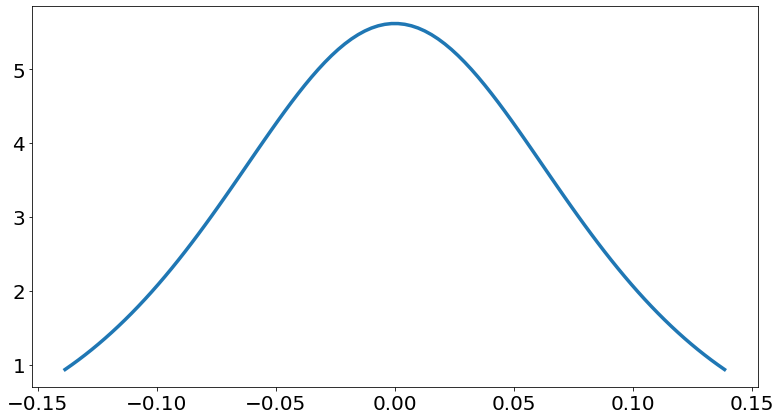

In [97]:
xs = np.linspace(-xbar, xbar, 100)
plt.plot(xs, g(xs));

# Also rewrite expectation iteration and functions
Same as before, but adding an extra $(1-\lambda)$ factor to account for free resets to zero:

In [101]:
xs = np.linspace(-xbar, xbar, 60)
def E_recursion(E):
    Exs = [integrate.quad(lambda xp: (1-lamb)*f(xp - x)*E(xp), -xbar, xbar)[0] for x in xs]
    return interpolate.CubicSpline(xs, Exs)

Rewrite code that calculates virtual and actual survival:

In [102]:
TPhi = 50
Phi_e = np.empty(TPhi)
Phi_i = np.empty(TPhi)
Phi_actual = np.empty(TPhi)

Et = interpolate.CubicSpline(xs, xs) # identity
Et_noreset = interpolate.CubicSpline(xs, np.ones(len(xs)))

for t in range(TPhi):
    Phi_e[t] = Et(xbar)/xbar
    Phi_i[t] = Et.derivative()(0)
    Phi_actual[t] = Et_noreset(0)
    Et = E_recursion(Et)
    Et_noreset = E_recursion(Et_noreset)

# What do hazards look like now?
Still converging to a constant, different from actual hazard, but it takes longer ($\overline{x}$ higher, so bigger difference between starting at $\overline{x}$ and $x^*=0$) and less of a gap:

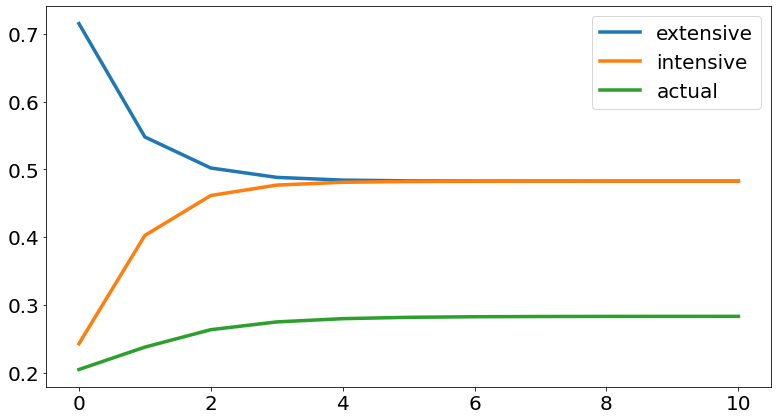

In [103]:
lamb_e = 1 - Phi_e[1:] / Phi_e[:-1]
lamb_i = 1 - Phi_i[1:] / Phi_i[:-1]
lamb_actual = 1 - Phi_actual[1:] / Phi_actual[:-1]
plt.plot(lamb_e[:11], label='extensive')
plt.plot(lamb_i[:11], label='intensive')
plt.plot(lamb_actual[:11], label='actual')
plt.legend();

# Calculate pass-through matrix now

In [104]:
Phi_e_long = np.zeros(T)
Phi_e_long[:TPhi] = Phi_e
Psi_e = Psi_td(Phi_e_long, beta)

Phi_i_long = np.zeros(T)
Phi_i_long[:TPhi] = Phi_i
Psi_i = Psi_td(Phi_i_long, beta)

Weight on extensive margin is smaller, because so many adjustments are free that it's less important:

In [105]:
alpha = 2*(1-lamb)*g(xbar)*xbar*Phi_e.sum()
alpha

0.32028114429238486

In [107]:
Psi = alpha*Psi_e + (1-alpha)*Psi_i

# Visualizing pass-through matrix
Less sharp spikes, corresponding to less flexible prices:

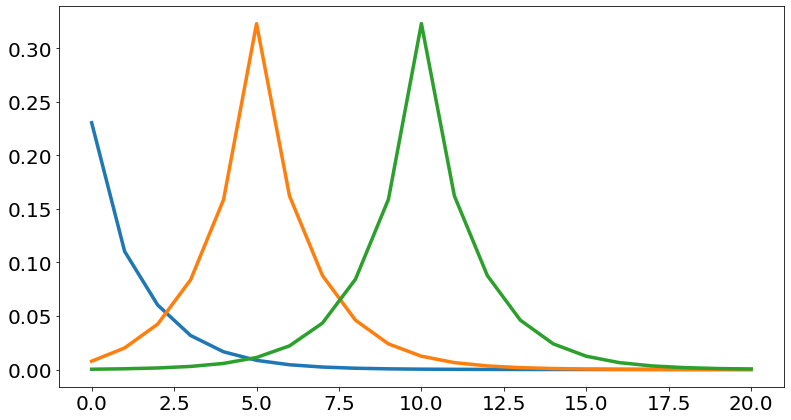

In [108]:
plt.plot(Psi[:21, [0, 5, 10]]);

# Generalized Phillips curve a bit less Calvo-like, but still *extremely* close
(If you run the NKPC as a regression on data that follows this, it still holds almost exactly.)

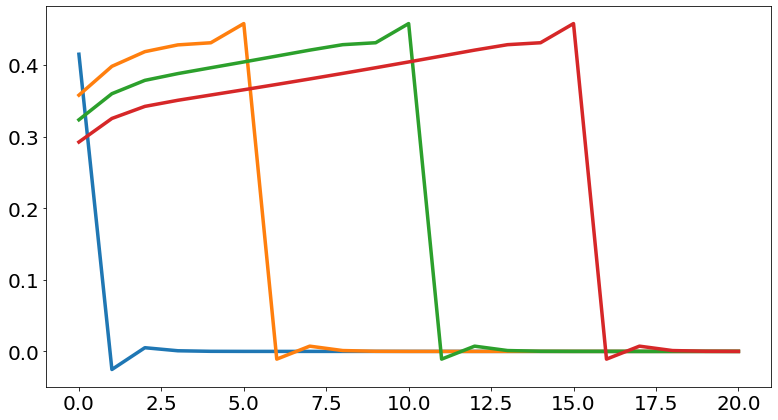

In [109]:
K = K_from_Psi(Psi)
plt.plot(K[:21, [0, 5, 10, 15]]);

# Paradox: making model more Calvo-like gives it a slightly less Calvo-like shape?

- Might seem like a paradox: why is the basic menu cost model a more perfect fit to the Calvo NKPC than a model with Calvo-like free-adjustments?


- Explanation of paradox: wider bands means that extensive and intensive virtual hazards more different, take longer to converge to constant hazard characteristic of Calvo
    * In limit of only free adjustments, converges to Calvo, but takes a while to get there...
    
    
- Paradox is only about *shape* rather than *scale*: slope is much closer to the Calvo case (but still higher)

# Generalizing the approach

- More time-dependent models needed with more distinct margins
    * asymmetries or drift from inflation: 3 models to represent separate lower and upper extensive margins
    * mean-reverting shocks: even more models
    * different objective functions or aggregation: slightly generalize TD model
    

- Go all the way to generalized hazard functions (cf Alvarez Lippi Oskolkov) in paper, requiring a *continuum* of TD models representing extensive margin


- Similar results should hold for similar models with fixed costs


- Near-equivalence to Calvo remarkably robust!

# Big picture for pricing models

- Hard to escape New Keynesian Phillips curve functional form!
    
    
- Menu cost models better-microfounded but worsen "slope puzzle" (gap between micro and macro) for the NKPC


- Some promising other routes
    * multisector (e.g. Rubbo; Afrouzi and Bhattarai)
    * departures from FIRE (e.g. Angeletos and Lian; also Ludwig's lecture for techniques!)

# Big picture for our techniques

- Generalizing sequence-space Jacobians to new kinds of models


- Example of simple discrete choice, in this case without taste shocks
    * Needed continuous shocks and to be careful about integration
    
    
- Equivalence result is really just the fake news algorithm in disguise
    * If you try to figure out what the algorithm means, you'll find it!